In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd


import lalsimulation.gwsignal.core.waveform as wfm
import astropy.units as u
from gwpy.frequencyseries import FrequencySeries

from gw_signal_tools.fisher_utils import (
    get_waveform_derivative_1D, get_waveform_derivative_1D_with_convergence
)
from gw_signal_tools.fisher_matrix import FisherMatrix

import warnings
warnings.filterwarnings('ignore', '.*This code is currently UNREVIEWED, use with caution!.*')

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [3]:
f_min = 20.*u.Hz
f_max = 1024.*u.Hz

wf_center_parameters = {
    # 'total_mass': 100.*u.solMass,
    'total_mass': 50.*u.solMass,
    'mass_ratio': 0.42*u.dimensionless_unscaled,
    'deltaT': 1./2048.*u.s,
    'f22_start': f_min,
    # 'deltaF': 2**-10*u.Hz,
    'deltaF': 2**-8*u.Hz,
    'f_max': f_max,
    'f22_ref': 20.*u.Hz,
    'phi_ref': 0.*u.rad,
    # 'distance': 1.*u.Mpc,
    'distance': 440.*u.Mpc,
    'inclination': 0.0*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    'spin1z': 0.42*u.dimensionless_unscaled,
    'condition': 0
}

# Define the approximant
approximant = 'IMRPhenomXPHM'
# approximant = 'SEOBNRv4'

# Initialize the generator
wf_generator = FisherMatrix.get_wf_generator(approximant)

## Derivative Testing

In [172]:
param_to_vary = 'total_mass'  # Agreement does not really depend on value of M
# param_to_vary = 'sym_mass_ratio'
# param_to_vary = 'mass_ratio'
# param_to_vary = 'distance'
# param_to_vary = 'spin1z'

* total_mass: very good agreement, 1e-6 relative difference for lower frequencies and not more than 1e-3 overall -> gets worse, 1e-2 for larger frequencies; is perhaps due to large influence of total mass on phase
* sym_mass_ratio: not perfect for 0.05, but this is very challenging territory
* mass_ratio: pretty good, relative differences are never larger than 1e-4 until $\approx 60 Hz$; larger for higher frequencies, but numdifftools error increases there drastically as well, which means this might not come from our implementation
* distance: really good for mass ratio 0.42 (1e-9 relative error), but for 0.5 it is not good, phases seem to differ quite a bit

In [173]:
num_deriv, info_dict = get_waveform_derivative_1D_with_convergence(
    wf_center_parameters,
    param_to_vary,
    wf_generator,
    convergence_check='diff_norm',
    # convergence_threshold=0.005,
    # convergence_threshold=0.0001,  # Testing if relative difference becomes smaller when doing this -> yes it does; but computation time also increases significantly
    return_info=True,
    step_sizes=np.reshape(np.outer([1e-3, 1e-4, 1e-5, 1e-6], [5, 2, 1]), -1)  # argument start_step_size?
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

{'norm_squared': <Quantity 1.17022184e-42 2.52923e-61 / kg2>, 'final_step_size': 0.001, 'final_convergence_val': <Quantity 0.00229729>, 'number_of_refinements': 0, 'final_set_of_step_sizes': array([5.e-03, 2.e-03, 1.e-03, 5.e-04, 2.e-04, 1.e-04, 5.e-05,
       2.e-05, 1.e-05, 5.e-06, 2.e-06, 1.e-06]), 'convergence_plot': <Axes: title={'center': 'Parameter: total_mass'}, xlabel='$f$', ylabel='Derivative'>}


/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/gwpy/plot/axes.py:190: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


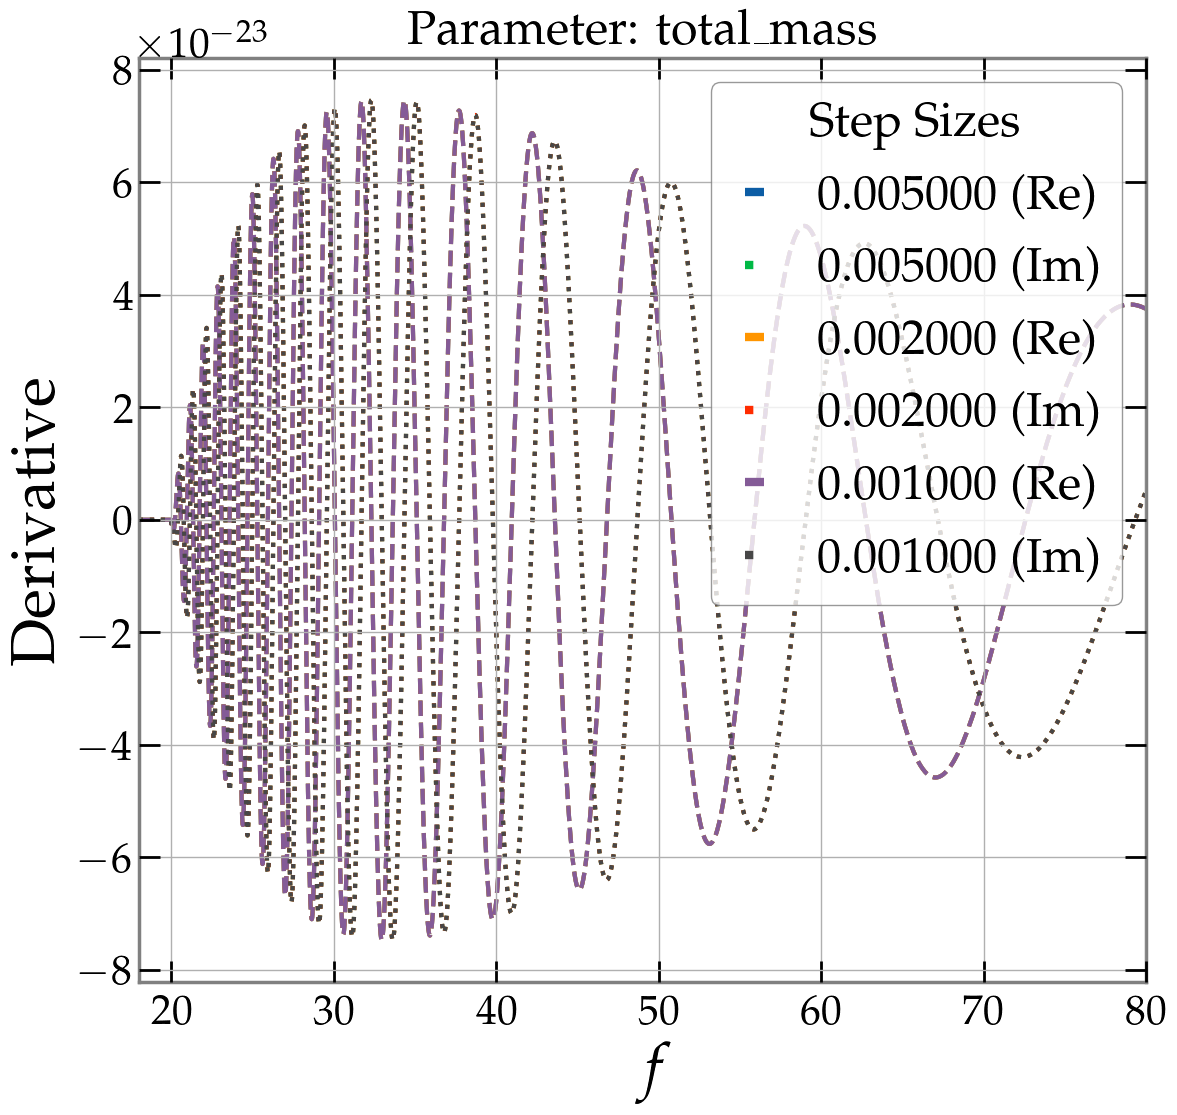

In [174]:
print(info_dict)

ax = info_dict['convergence_plot']

ax.set_xlim([18, 80])

plt.show()

In [175]:
def deriv_wrapper_real(param_val):
    # return np.real(wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0])
    # return wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0].real
    return wf_generator(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}).real

def deriv_wrapper_imag(param_val):
    # return np.imag(wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0])
    # return wfm.GenerateFDWaveform(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}, gen)[0].imag
    return wf_generator(wf_center_parameters | {param_to_vary: param_val * wf_center_parameters[param_to_vary].unit}).imag


center_val = wf_center_parameters[param_to_vary]


# max_step_size = None
max_step_size = 1e-2 * center_val.value  # Seems to cause issue sometimes, maybe use value of this?

nd_deriv_real = nd.Derivative(deriv_wrapper_real, full_output=True, base_step=max_step_size)

nd_deriv_imag = nd.Derivative(deriv_wrapper_imag, full_output=True, base_step=max_step_size)
# For more step size handling, see https://numdifftools.readthedocs.io/en/latest/reference/numdifftools.html#numdifftools.step_generators.BasicMaxStepGenerator

nd_deriv = FrequencySeries(
    nd_deriv_real(center_val)[0] + 1.j * nd_deriv_imag(center_val)[0],
    frequencies=num_deriv.frequencies,
    unit=num_deriv.unit
)

nd_deriv_error_est = FrequencySeries(
    nd_deriv_real(center_val)[1].error_estimate + 1.j * nd_deriv_imag(center_val)[1].error_estimate,
    frequencies=num_deriv.frequencies,
    unit=num_deriv.unit
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

Problem: fairly frequently, bounds of allowed parameter ranges are reached

/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/user/miniconda3/envs/gw_signal_tools/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


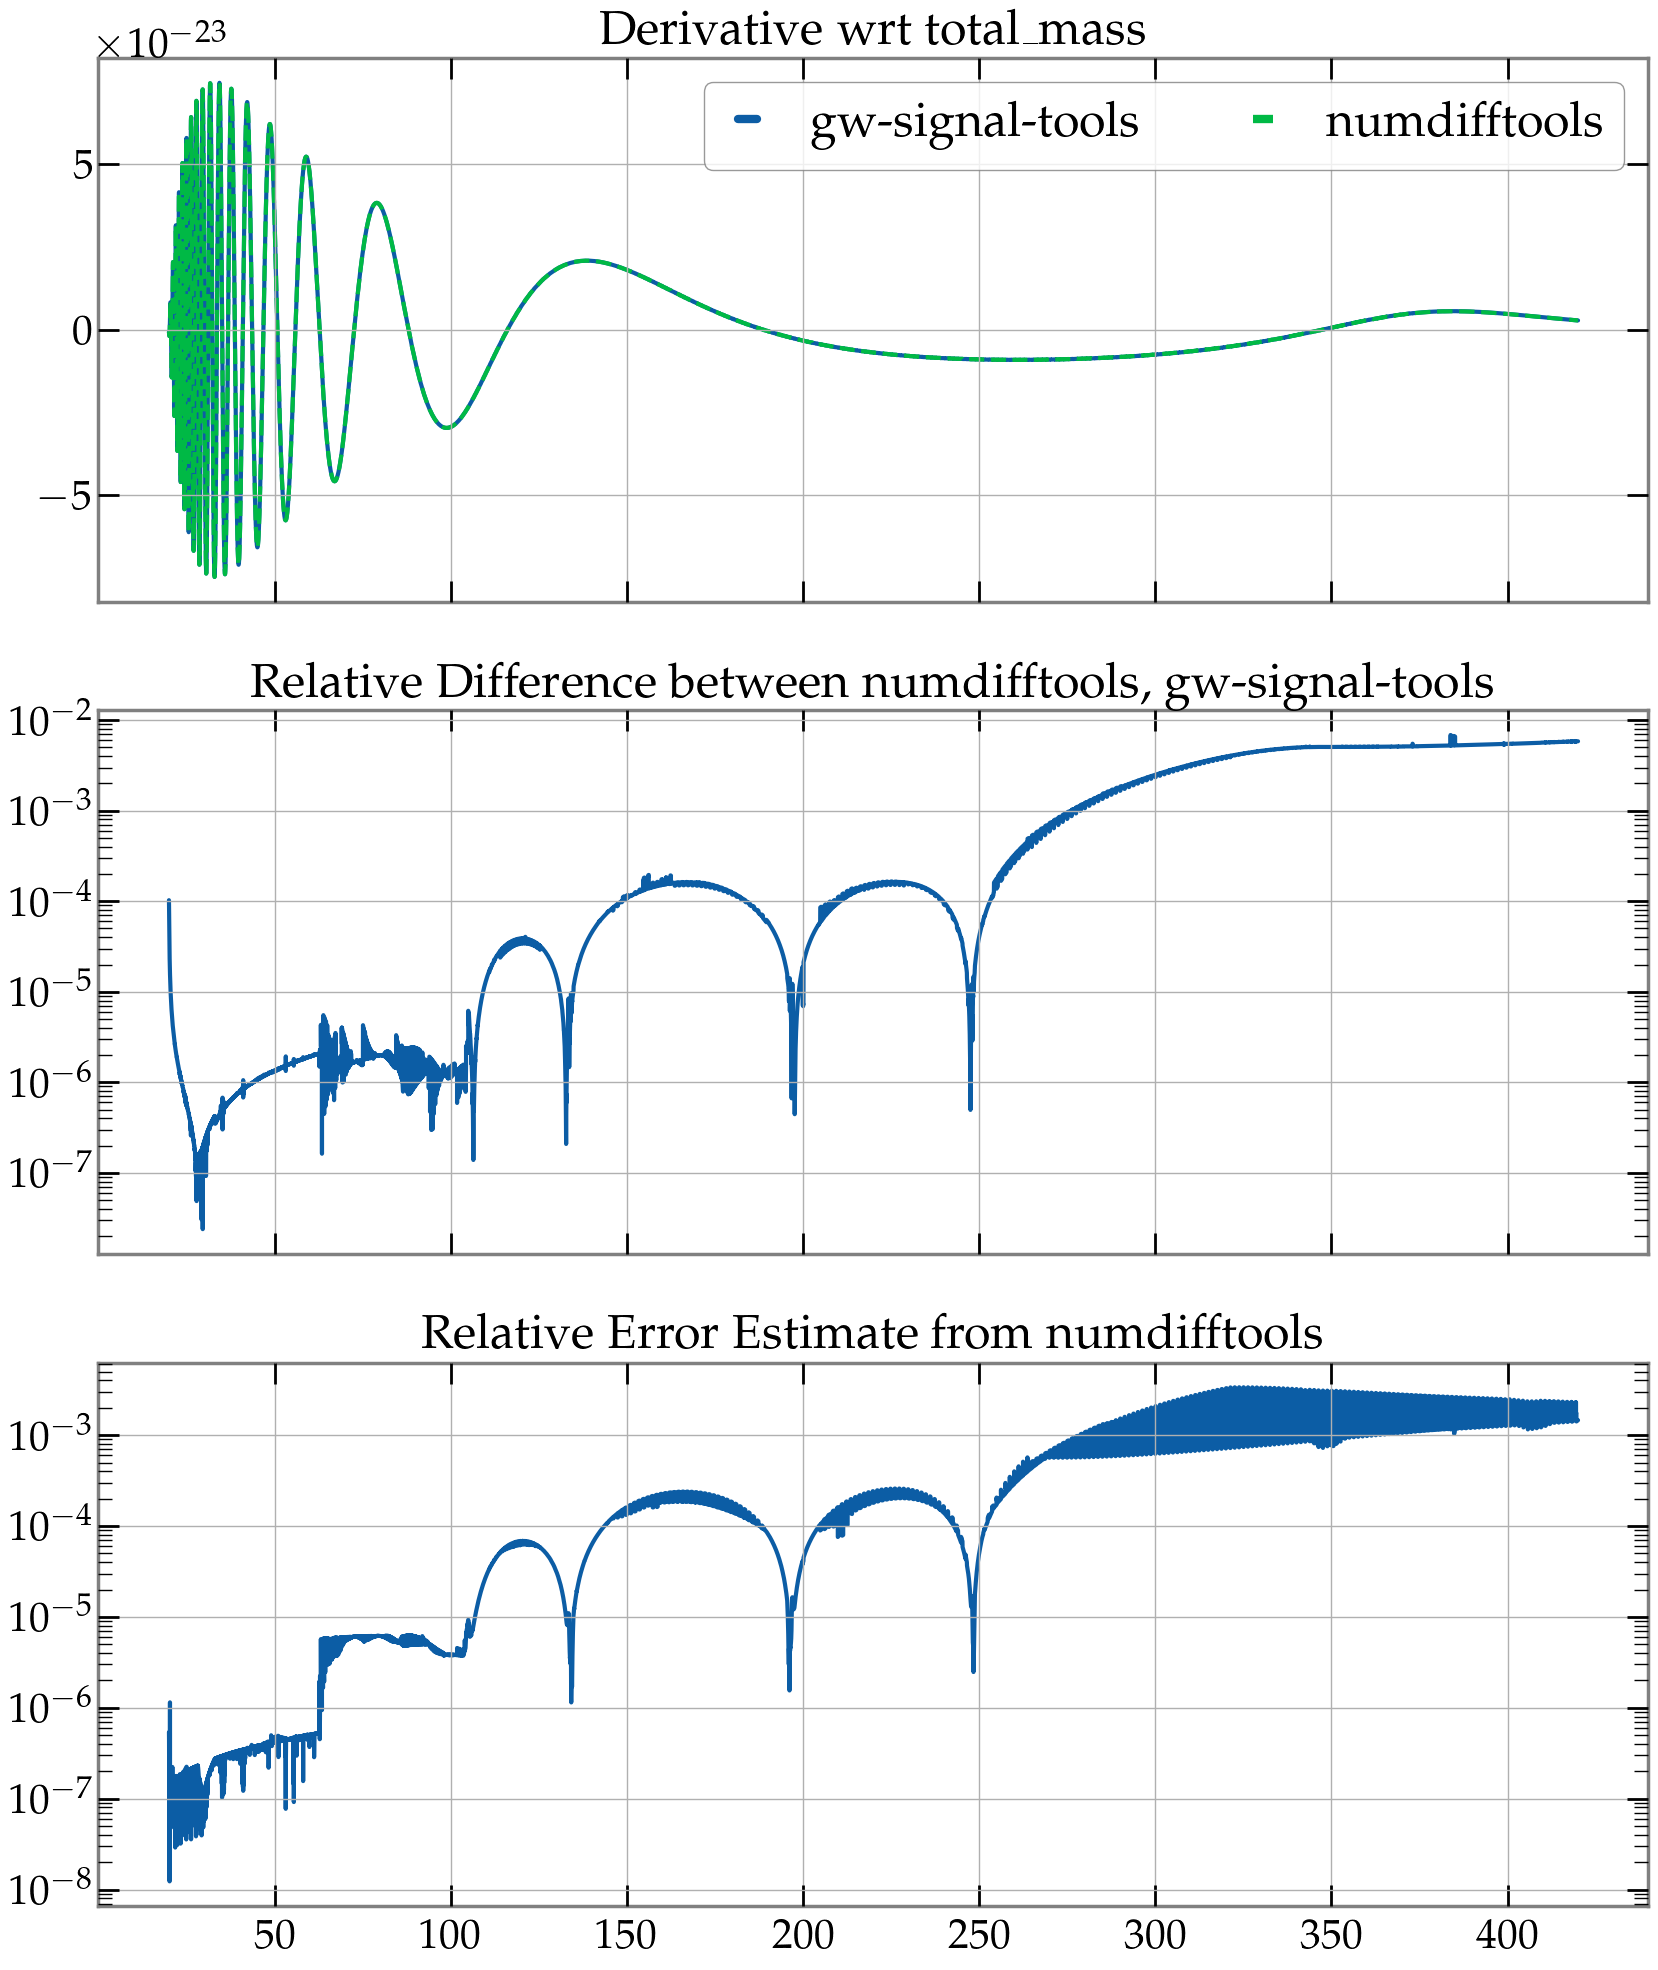

In [176]:
# f_range=[f_min, f_max]
# f_range=[f_min, 60. * u.Hz]
# f_range=[f_min, 200. * u.Hz]
f_range=[f_min, 420. * u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0,].plot(num_deriv.crop(start=f_range[0], end=f_range[1]), label='gw-signal-tools')
ax[0,].plot(nd_deriv.crop(start=f_range[0], end=f_range[1]), '--', label='numdifftools')

ax[0,].set_title(f'Derivative wrt {param_to_vary}')
ax[0,].legend(ncols=2)


ax[1,].plot(((num_deriv - nd_deriv) / num_deriv).abs().crop(start=f_range[0], end=f_range[1]))
# ax[1,].plot(nd_deriv.frequencies[nd_deriv.frequencies < f_cutoff], np.nan_to_num(((num_deriv - nd_deriv) / num_deriv).abs()).crop(end=f_cutoff))  # Same result, 0 not visible in log-plot

ax[1,].set_yscale('log')
ax[1,].set_title('Relative Difference between numdifftools, gw-signal-tools')


# ax[2,].plot(nd_deriv_error_est.crop(start=f_range[0], end=f_range[1]))
ax[2,].plot((nd_deriv_error_est / nd_deriv).abs().crop(start=f_range[0], end=f_range[1]))

ax[2,].set_yscale('log')
# ax[2,].set_title('Absolute Error Estimate from numdifftools')
ax[2,].set_title('Relative Error Estimate from numdifftools')

plt.show()

Relative difference on scale of error estimate is good, right? Should mean we get equal to numdifftools result that we are on scale of its error, i.e. the deviation need not come from our own implementation

In [177]:
from gw_signal_tools.inner_product import norm

In [178]:
f_range = None  # No restriction here

fisher1 = norm(num_deriv, f_range=f_range)
fisher2 = norm(nd_deriv, f_range=f_range)

In [179]:
print(fisher1, fisher2, abs((fisher1 - fisher2) / fisher1))

1.0817679236743781e-21 5.02914e-31 / kg 1.0815614809792384e-21 5.02914e-31 / kg 0.00019083824785495884


Agreement is good, only real deviations (around 1%) occur for extreme situations like very small symmetric mass ratio

## Verification with Analytical Derivatives

For the distance, we can calculate a analytical derivative by noticing that

$$h(f, D_L) = h(f, 1) / D_L$$

which implies

$$\frac{\partial h(f, D_L)}{\partial D_L} = h(f, 1) \frac{\partial 1/D_L}{\partial D_L} = h(f, 1) (-1 / D_L^2) = - h(f, D_L) / D_L .$$

In [18]:
num_deriv_distance, info_dict_distance = get_waveform_derivative_1D_with_convergence(
    wf_center_parameters,
    'distance',
    wf_generator,
    convergence_check='diff_norm',
    return_info=True,
)
plt.close()

ana_deriv_distance = - wf_generator(wf_center_parameters) * u.s / wf_center_parameters['distance']
# NOTE: multiplication with seconds is just because of inconsistent units in wf generation

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

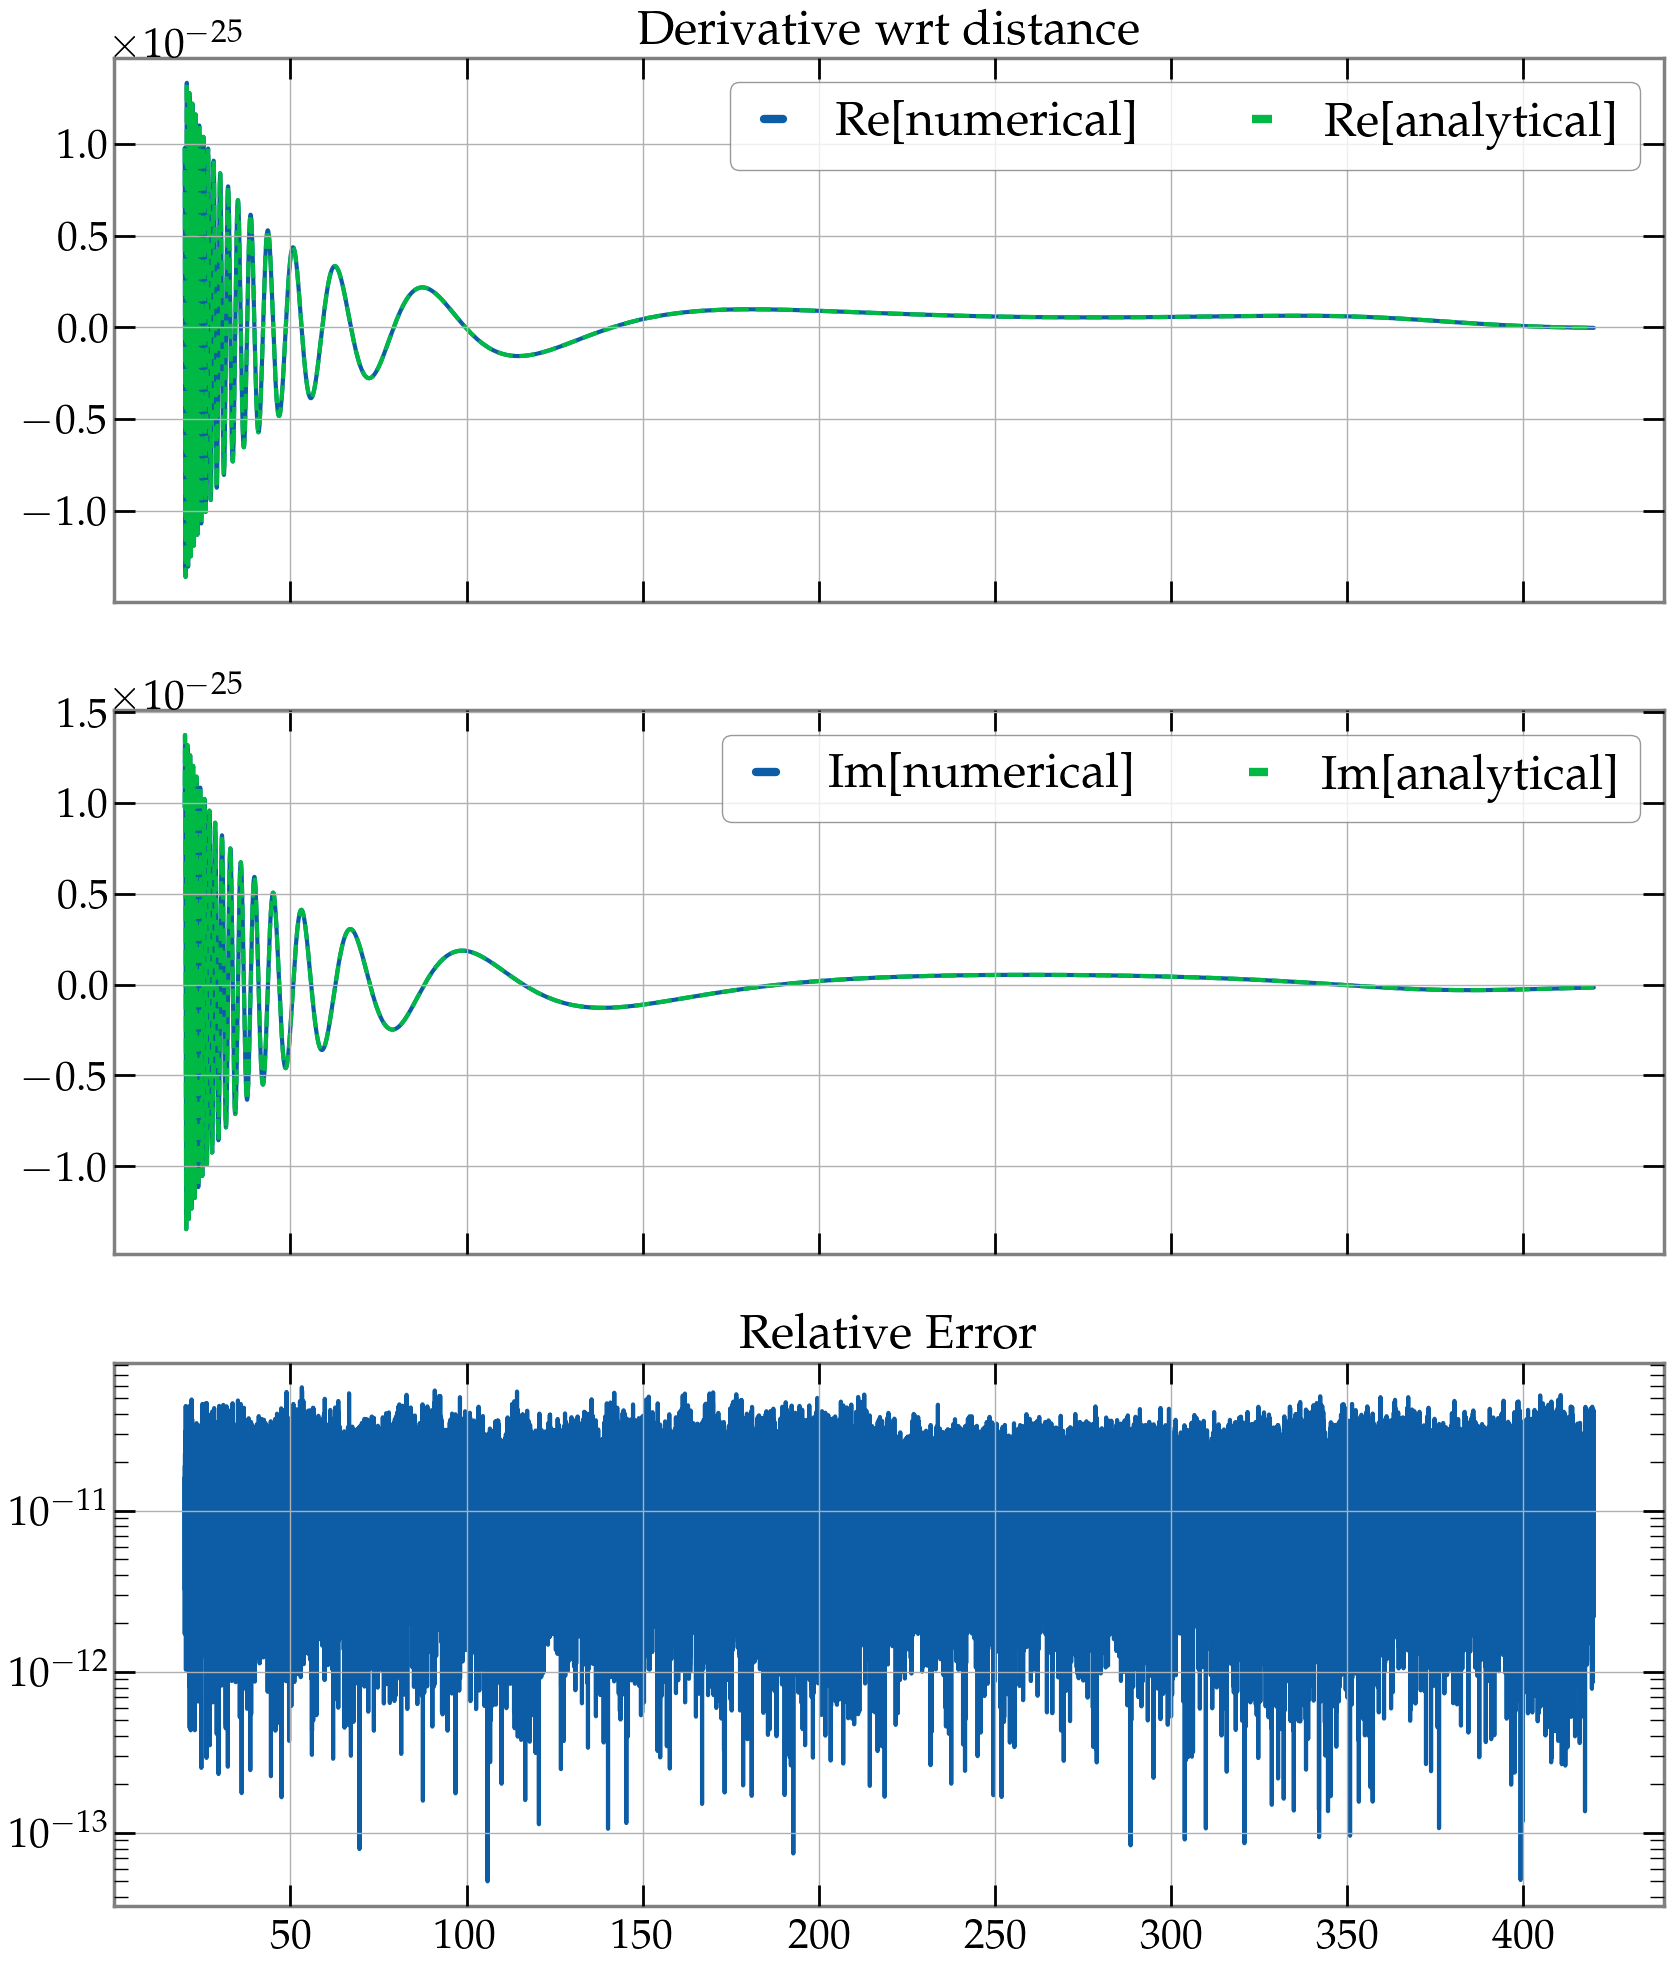

In [25]:
# f_range=[f_min, f_max]
# f_range=[f_min, 60. * u.Hz]
# f_range=[f_min, 200. * u.Hz]
f_range=[f_min, 420. * u.Hz]


fig, ax = plt.subplots(figsize=(20,24), nrows=3, sharex=True)

ax[0,].plot(num_deriv_distance.crop(start=f_range[0], end=f_range[1]).real, label='Re[numerical]')
ax[0,].plot(ana_deriv_distance.crop(start=f_range[0], end=f_range[1]).real, '--', label='Re[analytical]')

ax[0,].set_title(f'Derivative wrt {param_to_vary}')
ax[0,].legend(ncols=2)


ax[1,].plot(num_deriv_distance.crop(start=f_range[0], end=f_range[1]).imag, label='Im[numerical]')
ax[1,].plot(ana_deriv_distance.crop(start=f_range[0], end=f_range[1]).imag, '--', label='Im[analytical]')
ax[1,].legend(ncols=2)


ax[2,].plot(((ana_deriv_distance - num_deriv_distance) / ana_deriv_distance).abs().crop(start=f_range[0], end=f_range[1]))

ax[2,].set_yscale('log')
ax[2,].set_title('Relative Error')

plt.show()

The agreement is very good, verifying our algorithm (at least for this parameter)